# Homework on two-way fixed effects

The goal of the following homework is to develop our understanding of two-way fixed effect models. 

Related papers:
 - the original paper by [Abowd, Kramarz, and Margolis](https://onlinelibrary.wiley.com/doi/abs/10.1111/1468-0262.00020).
 - [Andrews et al paper](https://www.jstor.org/stable/30135090)
 

## Preparing the environment

In [1]:
using Pkg
Pkg.activate("..") # Create new environment in this folder

# first time you need to install dependencies
Pkg.add("Distributions")
Pkg.add("StatsBase")
Pkg.add(["DataFrames","DataFramesMeta","Chain"])
Pkg.add("Plots")

# past the first time, you only need to instanciate the current folder
Pkg.instantiate() # Updates packages given .toml file

  Activating new project at `~`
   Resolving package versions...
   Installed Compat ────── v4.15.0
   Installed FillArrays ── v1.11.0
   Installed AliasTables ─ v1.1.2
    Updating `~/Project.toml`
  [31c24e10] + Distributions v0.25.108
    Updating `~/Manifest.toml`
  [66dad0bd] + AliasTables v1.1.2
  [49dc2e85] + Calculus v0.5.1
  [34da2185] + Compat v4.15.0
  [9a962f9c] + DataAPI v1.16.0
  [864edb3b] + DataStructures v0.18.20
  [31c24e10] + Distributions v0.25.108
  [ffbed154] + DocStringExtensions v0.9.3
  [fa6b7ba4] + DualNumbers v0.6.8
  [1a297f60] + FillArrays v1.11.0
  [34004b35] + HypergeometricFunctions v0.3.23
  [92d709cd] + IrrationalConstants v0.2.2
  [692b3bcd] + JLLWrappers v1.5.0
  [2ab3a3ac] + LogExpFunctions v0.3.27
  [e1d29d7a] + Missings v1.2.0
  [77ba4419] + NaNMath v1.0.2
  [bac558e1] + OrderedCollections v1.6.3
  [90014a1f] + PDMats v0.11.31
  [21216c6a] + Preferences v1.4.3
  [1fd47b50] + QuadGK v2.9.4
  [189a3867] + Reexport v1.2.2
  [79098fc4] + Rmath v0.7.1


We then list our imports

In [2]:
using Distributions
using LinearAlgebra
using StatsBase
using DataFrames
using Plots

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


## Constructing Employer-Employee matched data

### Create a mobility matrix

One central piece is to have a network of workers and firms over time. We start by simulating such an object. The rest of the homework will focus on adding wages to this model. As we know from the lectures, a central issue of the network will be the number of movers.

We are going to model the mobility between workers and firms. Given a transition matrix we can solve for a stationary distribution, and then construct our panel from there.

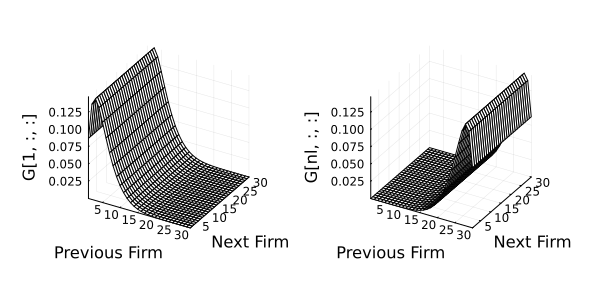

In [32]:
α_sd = 1
ψ_sd = 1

# approximate each distribution with some points of support
nk = 30 #number of firms 
nl = 10 # nuumber of workers
ψ = quantile.(Normal(), (1:nk) / (nk + 1)) * α_sd
#array where each element represents quantile of the std. normal corresponding to the probability generated by (1:nk) / (nk + 1)
α = quantile.(Normal(), (1:nl) / (nl + 1)) * ψ_sd

# Let's assume moving probability is fixed
λ = 0.1

csort = 1 # Sorting effect (0.5)
cnetw = 0 # Network effect (0.2)
csig  = 0.5 # Cross-sectional standard deviation

# Let's create type-specific transition matrices
# We are going to use joint normals centered on different values
G = zeros(nl, nk, nk)
#three-dimensional array filled with zeros. nl is the number of layers, nk is the number of rows and, nk is the number of columns
for l in 1:nl, k in 1:nk
    G[l, k, :] = pdf.( Normal(0, csig), ψ .- cnetw * ψ[k] .- csort * α[l])
    #pdf of dist.  Normal(0, csig) evaluated at ψ .- cnetw * ψ[k] .- csort * α[l]
    G[l, k, :] = G[l, k, :] ./ sum(G[l, k, :])
end

# We then solve for the stationary distribution over psis for each alpha value
# We apply a crude fixed point approach
H = ones(nl, nk) ./ nk
for l in 1:nl
    M = transpose(G[l, :, :])
    for i in 1:100
        H[l, :] = M * H[l, :]
    end
end

p1 = plot(G[1, :, :], xlabel="Previous Firm", ylabel="Next Firm", zlabel="G[1, :, :]", st=:wireframe)
p2 = plot(G[nl, :, :], xlabel="Previous Firm", ylabel="Next Firm", zlabel="G[nl, :, :]", st=:wireframe, right_margin = 10Plots.mm) # right_margin makes sure the figure isn't cut off on the right
plot(p1, p2, layout = (1, 2), size=[600,300])

And we can plot the joint distribution of matches

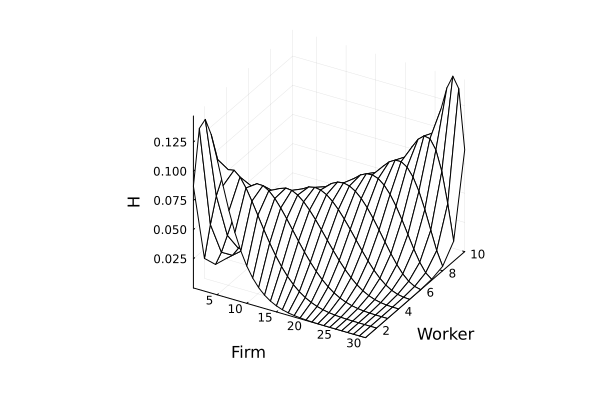

In [20]:
plot(H, xlabel="Firm", ylabel="Worker", zlabel="H", st=:wireframe)

<span style="color:green">Question 1</span>

 - Explain what the parameters `cnetw` and  `csort` do.

<span style="color:green">Answer 1</span>

`G[l,k]` is the transition matrix for worker `l` in pre-move firm `k`. In particular, it is the pdf of the normal distribution with mean `0` and variance `csig` evaluated at `ψ .- cnetw * ψ[k] .- csort * α[l]`.  Thus, `csort` captures the strength with which the worker fixed effects affect the probability of moving to another firm. For instance `csort` is zero, then the probability of moving is not affected by the worker fixed effects. 

On the other hand, `cnetw` captures the strength with which the pre-move firm fixed effects affect the probability of moving to another firm. 


### Simulate a panel

The next step is to simulate our network given our transition rules.

In [14]:
nt = 10
ni = 10000

# We simulate a balanced panel
ll = zeros(Int64, ni, nt) # Worker type
kk = zeros(Int64, ni, nt) # Firm type
spellcount = zeros(Int64, ni, nt) # Employment spell

for i in 1:ni
    
    # We draw the worker type
    l = rand(1:nl)
    ll[i,:] .= l
    
    # At time 1, we draw from H
    kk[i,1] = sample(1:nk, Weights(H[l, :]))
    
    for t in 2:nt
        if rand() < λ
            kk[i,t] = sample(1:nk, Weights(G[l, kk[i,t-1], :]))
            spellcount[i,t] = spellcount[i,t-1] + 1
        else
            kk[i,t] = kk[i,t-1]
            spellcount[i,t] = spellcount[i,t-1]
        end
    end
    
end

### Attach firm ids to types

The final step is to assign identities to the firms. We are going to do this is a relatively simple way, by simply randomly assigning firm ids to spells.

In [15]:
firms_per_type = 15
jj = zeros(Int64, ni, nt) # Firm identifiers

draw_firm_from_type(k) = sample(1:firms_per_type) + (k - 1) * firms_per_type

for i in 1:ni
    
    # extract firm type
    k = kk[i,1]
    
    # We draw the firm (one of firms_per_type in given group)
    jj[i,1] = draw_firm_from_type(k)
    
    for t in 2:nt
        if spellcount[i,t] == spellcount[i,t-1]
            # We keep the firm the same
            jj[i,t] = jj[i,t-1]
        else
            # We draw a new firm
            k = kk[i,t]
            
            new_j = draw_firm_from_type(k)            
            # Make sure the new firm is actually new
            while new_j == jj[i,t-1]
                new_j = draw_firm_from_type(k)
            end
            
            jj[i,t] = new_j
        end
    end
end

# Make sure firm ids are contiguous
contiguous_ids = Dict( unique(jj) .=> 1:length(unique(jj))  )
jj .= getindex.(Ref(contiguous_ids),jj);

<span style="color:green">Question 2</span>

 - Explain the last 2 lines, in particular `.=>` and the use of `Ref`. 

In [16]:
ii = repeat(1:ni,1,nt)
tt = repeat((1:nt)',ni,1)
df = DataFrame(i=ii[:], j=jj[:], l=ll[:], k=kk[:], α=α[ll[:]], ψ=ψ[kk[:]], t=tt[:], spell=spellcount[:]);

<span style="color:green">Question 3</span>

Use `Chain.jl` and `DataFramesMeta.jl` to compute:

 - mean firm size, in the crossection, expect something like 15.
 - mean number of movers per firm in total in our panel.


## Simulating AKM wages and create Event Study plot

We start with just AKM wages, which is log additive with some noise.

In [17]:
w_sigma = 0.2
df[!, :lw] = df.α + df.ψ + w_sigma * rand(Normal(), size(df)[1]);

<span style="color:green">Question 4</span>

Before we finish with the simulation code. Use this generated data to create the event study plot from [Card. Heining, and Kline](https://doi.org/10.1093/qje/qjt006):

1. Compute the mean wage within firm
2. Group firms into quartiles
3. Select workers around a move (2 periods pre, 2 periods post)
4. Compute wages before/after the move for each transition (from each quartile to each quartile)
5. Plot the lines associated with each transition

## Calibrating the parameters

<span style="color:green">Question 5</span>

 - Pick the parameters `psi_sd`, `alpha_sd`, `csort`, `csig`, and `w_sigma` to roughly match the decomposition in the Card-Heining-Kline paper (note that they often report numbers in standard deviations, not in variances).

## Estimating two-way fixed effects

This requires first extracting the large set of firms connected by movers, and then estimating the linear problem with many dummies.

### Extracting the connected set

Because we are not going to deal with extremely large data-sets, we can use off-the-shelf algorithms to extract the connected set. Use the function `connected_components` from the package `LightGraphs` to extract the connected set from our data. To do so you will need to first construct an adjacency matrix between the firms. 

<span style="color:green">Question 6</span>

 - Extract the connected set and drop firms not in the set (I expect that all firms will be in the set).

### Estimating worker and firm FEs

This part of the problem set is for you to implement the AKM estimator. As discussed in class, this can be done simply by updating, in turn, the worker FE and the firm FE.

Start by appending 2 new columns `alpha_hat` and `psi_hat` to your data. Then loop over the following:

1. Update `alpha_hat` by taking the mean within `i` net of firm FE
2. Update `psi_hat` by taking the mean within `fid` net of worker FE

<span style="color:green">Question 7</span>

 - Run the previous steps in a loop, and at each step evaluate how much the total mean square error has changed. Check that is goes down with every step. Stop when the MSE decreases by less than 1e-9.


Note that you can increase speed by focusing on movers only first.



## Limited mobility bias 

We now have everything we need to look at the impact of limited mobility bias. Compute the following:

1. Compute the estimated variance of firm FE
2. Do it for varying levels of mobility λ. For each the number of movers, collect the actual variance and the estimated variance. Run it for different panel lengths: 5, 6, 8, 10, 15.

<span style="color:green">Question 8</span>

 - Report this in a plot. This should look like the [Andrews et al.](https://www.sciencedirect.com/science/article/pii/S0165176512004272) plot.
 - Redo the exercise for the covariance between co-workers fixed effect as discussed in class.

## Correcting the bias (Start of homework Part 2)

<span style="color:green">Question 9</span>

 - Implement both the exact as well as the approximated (Hutchkinson trace approximation) Andrews et al. type fixed-effect bias correction based on homoskedacity. Redo the plot from Question 6 so that it includes these 2 estimates.

## Evidence of learning

<span style="color:green">Question 10</span>

 - Regress the wage of a worker at time $t$ on his wage at time $t-l$ and the average wage of his co-workers at time $t-l$ for some lags $l$ focusing on workers that did change firms between $t-l$ and $t$. 
 - Comment on the result.
